<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/014_tf2_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import skimage
import numpy as np
import tensorflow as tf

In [2]:
!wget http://download.tensorflow.org/example_images/flower_photos.tgz

--2021-02-14 13:18:22--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.15.80, 2607:f8b0:4004:810::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.15.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   333MB/s    in 0.7s    

2021-02-14 13:18:23 (333 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
!tar   zxvf    /content/flower_photos.tgz

In [4]:
#划分数据集为 train / val 
import shutil

images_dir='/content/flower_photos'
import os
save_train_imgs='/content/flowerdataset/train'
save_validiation_imgs = '/content/flowerdataset/val'
if not os.path.exists(save_train_imgs):os.makedirs(save_train_imgs)
if not os.path.exists(save_validiation_imgs):os.makedirs(save_validiation_imgs)
for parent, dirnames, filenames in os.walk(images_dir):
    for dirname in dirnames:
      class_path = os.path.join(images_dir, dirname)
      for parent1, dirnames1, filenames1 in os.walk(class_path):
        for i,filenames1 in enumerate(filenames1):
          img_path = os.path.join(class_path, filenames1)
          if i % 5 == 0:
            new_path_v = os.path.join(save_validiation_imgs, dirname)
            if not os.path.exists(new_path_v):os.makedirs(new_path_v)
            new_img_path_v = os.path.join(new_path_v, filenames1)
            shutil.move(img_path, new_img_path_v)
          else:
            new_path_t = os.path.join(save_train_imgs, dirname)
            if not os.path.exists(new_path_t):os.makedirs(new_path_t)
            new_img_path_t = os.path.join(new_path_t, filenames1)
            shutil.move(img_path, new_img_path_t)
    

In [2]:
#导入相应的库
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model, Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import tensorflow as tf
import json
import os

In [3]:
#设置图片的大小，路径，batch_size,epoch
im_height = 224
im_width = 224
batch_size = 128
epochs = 15

train_dir = "/content/flowerdataset/train/"
validation_dir = "/content/flowerdataset/val/"

In [4]:
# 图像预处理（训练集图片运用图像增强）
train_image_generator = ImageDataGenerator( rescale=1./255,
                                            rotation_range=40,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            zoom_range=0.2,
                                            horizontal_flip=True,
                                            fill_mode='nearest')
# 图像预处理
validation_image_generator = ImageDataGenerator(rescale=1./255)

#训练集数据生成器，one-hot编码，打乱数据
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(im_height, im_width),
                                                           class_mode='categorical')
#训练集图片总数
total_train = train_data_gen.n
#验证集数据生成器
val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir,
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              target_size=(im_height, im_width),
                                                              class_mode='categorical')
#验证集图片总数
total_val = val_data_gen.n


Found 2934 images belonging to 5 classes.
Found 736 images belonging to 5 classes.


In [10]:
#VGG16预训练网络
covn_base = tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False)
covn_base.trainable = True
#冻结前面的层，训练最后四层
for layers in covn_base.layers[:-4]:
    layers.trainable = False
#构建模型
model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 7,212,037
Non-trainable params: 7,635,264
_________________________________________________________________


In [11]:
#编译模型，初始学习率0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])
#监视'val_loss'，当两个epoch不变时，学习率减小为1/10
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
#开始训练
history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size,
                    callbacks=[reduce_lr])

Epoch 1/15
22/22 [==============================] - 48s 2s/step - loss: 1.7155 - accuracy: 0.2280 - val_loss: 1.4554 - val_accuracy: 0.2891
Epoch 2/15
22/22 [==============================] - 41s 2s/step - loss: 1.4099 - accuracy: 0.3647 - val_loss: 1.3132 - val_accuracy: 0.3297
Epoch 3/15
22/22 [==============================] - 41s 2s/step - loss: 1.2692 - accuracy: 0.4261 - val_loss: 1.2292 - val_accuracy: 0.3797
Epoch 4/15
22/22 [==============================] - 41s 2s/step - loss: 1.1893 - accuracy: 0.4639 - val_loss: 1.2916 - val_accuracy: 0.3438
Epoch 5/15
22/22 [==============================] - 41s 2s/step - loss: 1.2078 - accuracy: 0.4586 - val_loss: 1.0575 - val_accuracy: 0.5063
Epoch 6/15
22/22 [==============================] - 40s 2s/step - loss: 0.9212 - accuracy: 0.5906 - val_loss: 0.6835 - val_accuracy: 0.7422
Epoch 7/15
22/22 [==============================] - 41s 2s/step - loss: 0.7433 - accuracy: 0.6965 - val_loss: 0.5148 - val_accuracy: 0.7969
Epoch 8/15
22/22 [==

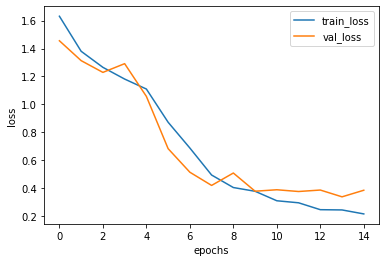

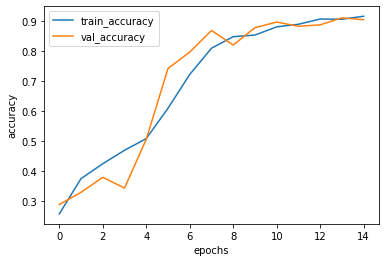

In [12]:
# 记录准确率和损失值
history_dict = history.history
train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

# 绘制损失值
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# 绘制准确率
plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

方案2 -- 没有预训练

In [13]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [22]:
#设置图片的大小，路径，batch_size,epoch
image_size = (224,224)
batch_size = 32
epochs = 20

image_path = "/content/flower_photos"

train_dataset = image_dataset_from_directory(image_path,
                                       labels="inferred",
                                       batch_size=batch_size,
                                       color_mode="rgb",
                                       shuffle=True,
                                       image_size=image_size,
                                       validation_split=0.2,
                                       seed=214,
                                       label_mode ='categorical',
                                       subset="training"
                                       )
validation_dataset = image_dataset_from_directory(image_path,
                                       labels="inferred",
                                       batch_size=batch_size,
                                       color_mode="rgb",
                                       shuffle=True,
                                       seed=214,
                                       image_size=image_size,
                                       validation_split=0.2,
                                       subset="validation",
                                       label_mode ='categorical'
                                       )



Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [34]:
VGG_MEAN = [103.939, 116.779, 123.68]

# define input layer
input_layer = tf.keras.layers.Input([224, 224, 3])
red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=input_layer)
bgr = tf.concat(axis=3, values=[blue - VGG_MEAN[0], green - VGG_MEAN[1], red - VGG_MEAN[2]])
#bgr = tf.concat(axis=3, values=[blue, green, red])
# Block 1
conv1_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv1_1')(input_layer)

conv1_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv1_2')(conv1_1)
pool1_1 = tf.nn.max_pool(conv1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1_1')

# Block 2
conv2_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv2_1')(pool1_1)
conv2_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv2_2')(conv2_1)
pool2_1 = tf.nn.max_pool(conv2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2_1')

# Block 3
conv3_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv3_1')(pool2_1)
conv3_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv3_2')(conv3_1)
conv3_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv3_3')(conv3_2)
pool3_1 = tf.nn.max_pool(conv3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool3_1')

# Block 4
conv4_1 = tf.keras.layers.Conv2D(filters=512, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv4_1')(pool3_1)
conv4_2 = tf.keras.layers.Conv2D(filters=512, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv4_2')(conv4_1)
conv4_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv4_3')(conv4_2)
pool4_1 = tf.nn.max_pool(conv4_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool4_1')


# Block 4
conv5_1 = tf.keras.layers.Conv2D(filters=512, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv5_1')(pool4_1)
conv5_2 = tf.keras.layers.Conv2D(filters=512, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv5_2')(conv5_1)
conv5_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=[3, 3], strides=[1, 1], padding='same',
                                 use_bias=True, activation='relu', name='conv5_3')(conv5_2)
pool5_1 = tf.nn.max_pool(conv5_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool5_1')

flatten = tf.keras.layers.Flatten()(pool5_1)
fc6 = tf.keras.layers.Dense(units=4096, use_bias=True, name='fc6', activation='relu')(flatten)
fc7 = tf.keras.layers.Dense(units=256, use_bias=True, name='fc7', activation='relu')(fc6)
fc8 = tf.keras.layers.Dense(units=5, use_bias=True, name='fc8', activation=None)(fc7)


prob = tf.nn.softmax(fc8)

# Build model
model_1 = tf.keras.Model(input_layer, prob)

In [35]:
model_1.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
tf.nn.max_pool2d_40 (TFOpLam (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
tf.nn.max_pool2d_41 (TFOpLam (None, 56, 56, 128)       0   

In [36]:
#编译模型，初始学习率0.001
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])
#监视'val_loss'，当两个epoch不变时，学习率减小为1/10
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
#开始训练
history = model_1.fit(train_dataset,
                    #steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    #validation_steps=total_val // batch_size,
                    #callbacks=[reduce_lr]
                    )

Epoch 1/20
92/92 [==============================] - 47s 502ms/step - loss: 193.6306 - accuracy: 0.2290 - val_loss: 1.5899 - val_accuracy: 0.2071
Epoch 2/20
92/92 [==============================] - 47s 504ms/step - loss: 1.8061 - accuracy: 0.2742 - val_loss: 1.6044 - val_accuracy: 0.2302
Epoch 3/20
92/92 [==============================] - 47s 508ms/step - loss: 1.6060 - accuracy: 0.2612 - val_loss: 1.6003 - val_accuracy: 0.2302
Epoch 4/20
92/92 [==============================] - 48s 512ms/step - loss: 1.5955 - accuracy: 0.2433 - val_loss: 1.5907 - val_accuracy: 0.2888
Epoch 5/20
92/92 [==============================] - 48s 516ms/step - loss: 1.5341 - accuracy: 0.3183 - val_loss: 1.4503 - val_accuracy: 0.3733
Epoch 6/20
92/92 [==============================] - 48s 519ms/step - loss: 1.4767 - accuracy: 0.3478 - val_loss: 1.4237 - val_accuracy: 0.3787
Epoch 7/20
92/92 [==============================] - 48s 519ms/step - loss: 1.4160 - accuracy: 0.3803 - val_loss: 1.3410 - val_accuracy: 0.44

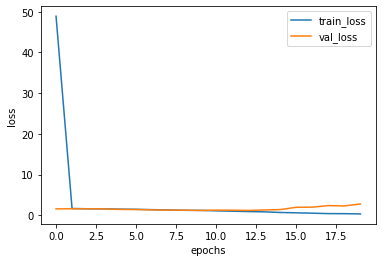

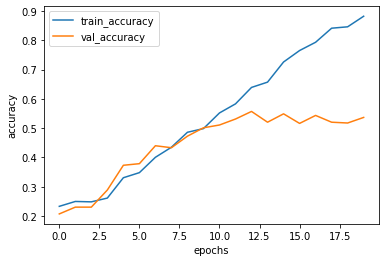

In [37]:
# 记录准确率和损失值
history_dict = history.history
train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

# 绘制损失值
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# 绘制准确率
plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()